<a href="https://colab.research.google.com/github/spectrochempy/spectrochempy_tutorials/blob/main/colab/2025_MecaReact_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='6'> MecaReact 2025: Spectra Analysis tutorial</font>

This tutorial shows how to handle and process the uv-vis dataset example with the python API **SpectroChemPy** (nicknamed scp or scpy) and **Google Colab**.

SpectroChemPy is not pre-installed in Colab. It is therefore necessary to install it before using it.

To do this, we execute the following shell command (`! pip install spectrochempy ...`). The execution time is < 1min ...

Once done, you can run the second cell below (`import numpy as np...`) to start the tutorial !

In [ ]:
! pip install spectrochempy &>> log

... and then import the modules and API:

In [ ]:
import numpy as np
import spectrochempy as scp

### 1. MCR ALS example with kinetic constraints

In this example, we perform the MCR ALS optimization of the UV-vis of spectra resulting from a three-component reaction A -> B -> C which was investigated by UV–Vis spectroscopy. Full details on the reaction and data acquisition conditions can be found in Bijlsma et al. [2001] . The data can be downloded from the author website Biosystems Data Analysis group University of Amsterdam (Copyright 2005 Biosystems Data Analysis Group ; Universiteit van Amsterdam ). For convenience, this dataset is present in the ‘datadir’ of spectrochempy in ‘matlabdata/METING9.MAT’.
For sake of demonstration, we will focus on a single run. For this example, we extract only the data for the run #9 (dataset name: 'x9b' ).


In [ ]:
ds = scp.read("matlabdata/METING9.MAT")

Makes a NDDataset with coordinates, titles, etc..

In [ ]:
D = scp.NDDataset(ds[1][:, 1:].data.T)
D.y = scp.Coord(ds[0].data.squeeze(), title="time") / 60
D.x = scp.Coord(ds[1][:, 0].data.squeeze(), title="wavelength / cm$^{-1}$")
D = D[::4]
D.plot()

# select spoectra and range of interest
D = D[:,:500.]

Plot spectra and spectra difference

In [ ]:
_ = (D - D.mean(dim=0)).plot(colorbar=True)
scp.show()

### 2. Generalized 2D COS: synchronous spectrum

Here we limit the analysis to the correlation spectrum, a.k.a. the coviriance matrix. As 2D COS is not (yet) implemented in spectrochempy, we use the `cov()` method implemented in numpy and make a dataset with the appropirate coordinates

In [ ]:
cov = scp.NDDataset(np.cov(D.T))
cov.title = 'covariance'
cov.set_coordset(D.x, D.x)
cov[:450.,:450.].plot(method="image", image_cmap="viridis", colorbar=True)

scp.show()

### 3. Principal Component Analysis

We make a PCA with 5 components, which is generally largely enough in practical cases

In [ ]:
pca = scp.PCA(n_components=5)
pca.fit(D)

# plot the loadings
pca.loadings.plot()
scp.show()

# plot the scores
pca.scores.T.plot()
scp.show()

# print the figures of merit
pca.printev()

The representation of the spectra in the space spanned by the principal components can be obtained by the so-calles score plots

In [ ]:
_ = pca.scoreplot(1,2)
scp.show()
_ = pca.scoreplot(1,2,3)
scp.show()

Now let's look as to how the fisrt PC's actually describe the experimental spectra.

The first line below makes the computation for the 1st component (index 0).
$$\hat{D} = \mathbf{t_1} \mathbf{p_1^t} + \bar{D}$$
The remaining lines are just here to get a nice plot...

In [ ]:
Dhat = scp.dot(pca.scores[:,0], pca.loadings[0]) + D.mean(dim=0).data
D.plot(cmap=None, color='dodgerblue')
ax = Dhat.plot(cmap=None, color='limegreen', clear=False)
(D - Dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()


In [ ]:
Dhat = scp.dot(pca.scores[:,0:2], pca.loadings[0:2]) + D.mean(dim=0).data
D.plot(cmap=None, color='dodgerblue')
ax = Dhat.plot(cmap=None, color='limegreen', clear=False)
(D - Dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()

Anf finally for the three first components:

In [ ]:
Dhat = scp.dot(pca.scores[:,0:3], pca.loadings[0:3]) + D.mean(dim=0).data
D.plot(cmap=None, color='dodgerblue')
ax = Dhat.plot(cmap=None, color='limegreen', clear=False)
(D - Dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()

### 4. Evolving Factor Analysis

We first perform the EFA and plot formward and backward analyses:



In [ ]:
efa = scp.EFA(n_components=3)
efa.fit(D)

# plot Forward and reverse
np.log10(efa.f_ev.clip(1e-5)).T.plot(cmap=None, color='dodgerblue')
np.log10(efa.b_ev.clip(1e-5)).T.plot(clear=False, cmap=None, color='limegreen')
scp.show()

Now get and plot the corresponding concentrations

In [ ]:
C = efa.transform()
_ = C.T.plot()

Note that this profile can be normalized, for instance to its maximum...;

In [ ]:
C_normed = C/C.max(dim=0)
_ = C_normed.T.plot()

### 3. SIMPLISMA

As an introduction, let's get the get the purity spectrum. The first line of the following code cell is equivalent to:

$$ p(\nu) = \frac{\sigma}{\bar{D}(\nu) + 0.03 \bar{D}}$$

In [ ]:
p = D.std(dim=0)/(D.mean(dim=0) + 0.03 * np.mean(D))
p.plot()
scp.show()

Next, we perform an unsupervised SIMPLISMA with 3 (or less) components

In [ ]:
sim = scp.SIMPLISMA(n_components=3, tol=0.1)
sim.fit(D)

# and plot spectra
sim.St.plot()
scp.show()

As seen above, only two components are obtained while we asked for 3: this is because the default convergence criterion is obtained reached with 2 components.

### 5. Soft MCR ALS

Here, we will explore the data usi,g MCR ALS with 2 to 3 components abd various guesses.


#### a) 2 components, guess from spectra

First we use 2 components gusessed by the first and last spectrum as guess

In [ ]:
# guess spectra
St0 = scp.concatenate((D[0], D[-1]), axis=0)
St0.plot(title="guess spectra"); scp.show()

# compute MCRALS
mcr_0 = scp.MCRALS(log_level='INFO')
mcr_0 = mcr_0.fit(D, St0)

# plot C, St and merit:
mcr_0.C.T.plot(); scp.show()
mcr_0.St.plot(); scp.show()
mcr_0.plotmerit(nb_traces=5); scp.show()

#### b)  3 componnents, guess from spectra

We take the first, middle and last spectrum as guess:

In [ ]:
# guess spectra
St0 = scp.concatenate((D[0], D[len(D.y)//2], D[-1]), axis=0)
St0.plot(title="guess spectra"); scp.show()

# compute MCR ALS
mcr_1 = scp.MCRALS(log_level='INFO')
mcr_1.solverConc = 'nnls'
mcr_1.closureConc = [0,1,2]
mcr_1 = mcr_1.fit(D, St0)

# plot results
mcr_1.C.T.plot(); scp.show()
mcr_1.St.plot(); scp.show()
mcr_1.plotmerit(nb_traces=5)
scp.show()

#### c) 3 components, guess from intensities

In [ ]:
# MCR ALS, 3 componnents, intensities as guess

C0 = scp.concatenate((D[:,340.], D[:,260.], D[:,240.]), axis=1)
C0.T.plot(title="Intensities, guess concentrations")

mcr_2 = scp.MCRALS(log_level='INFO')
mcr_2.solverConc = 'nnls'
mcr_2.closureConc = [0,1,2]
mcr_2 = mcr_2.fit(D, C0)

mcr_2.C.T.plot()
scp.show()
mcr_2.St.plot()
ax = mcr_2.plotmerit(nb_traces=10)

#### d) 4 components, guess from EFA

In [ ]:
efa = scp.EFA(n_components=3)
efa.fit(D)
C0 = efa.transform()
C0 = C0 / C0.max(dim=0)
C0.T.plot(title='EFA guess concentrations (normalized)')
scp.show()

mcr_3 = scp.MCRALS(log_level='INFO')
mcr_3.solverConc = 'nnls'
mcr_3.closureConc = [0,1,2]
mcr_3 = mcr_2.fit(D, C0)

mcr_3.C.T.plot(); scp.show()
mcr_3.St.plot(); scp.show()
mcr_3.plotmerit(nb_traces=5); scp.show()


### hard-soft MCR-ALS with kinietic constraints



#### a) Initial kinetic model: A → B → C

We first create a A → B → C kinetic model with guess values for the rate constants. For instance they can be manually adjusted using a visul comparions or estimates from the initial slope (k1) and position of the maximum (k2).

In [ ]:
# setup initial model
reactions = ("A -> B", "B -> C")
species_concentrations = {"A": 1.0, "B": 0.0, "C": 0.0}
k0 = np.array((0.5, 0.05))
kin = scp.ActionMassKinetics(reactions, species_concentrations, k0)
Ckin = kin.integrate(D.y.data)

# compare concentrations
_ = mcr_3.C.T.plot()
_ = Ckin.T.plot(clear=False, ls='dashed')


Once manually adjusted, this concentration profile can be used as a guess and further adjusted in the MCR-ALS loop:

In [ ]:
param_to_optimize = {"k[0]": k0[0], "k[1]": k0[1]}
mcr_5 = scp.MCRALS()
mcr_5.hardConc = [0, 1, 2]
mcr_5.getConc = kin.fit_to_concentrations
mcr_5.argsGetConc = ([0, 1, 2], [0, 1, 2], param_to_optimize)
mcr_5.kwargsGetConc = {"ivp_solver_kwargs": {"return_NDDataset": False}}

mcr_5.fit(D, Ckin)

# %%
_ = mcr_5.C.T.plot()
_ = mcr_5.C_constrained.T.plot(clear=False, ls='dashed')
scp.show()

# %%
mcr_5.St.plot()
scp.show()
ax = mcr_5.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)


The fit of experimental is very good (nearly as good as PCA), but the MCR ALS concentration profile slightly differs from the profile predicted by the kinetic model. This can be indicativbe that the kinetic model can be improved...

#### b) Final model: A ↔ B → C

Actually the first reactioin is reversible. We can thus improve the model by adding a supplementary step:

In [ ]:
# Final model, reversible reactions

reactions = ("A -> B", "B -> A", "B -> C")
species_concentrations = {"A": 1.0, "B": 0.0, "C": 0.0}
k0 = np.array((0.25, 0.05, 0.04))
kin = scp.ActionMassKinetics(reactions, species_concentrations, k0)

Ckin = kin.integrate(D.y.data)
_ = mcr_5.C.T.plot()
_ = Ckin.T.plot(clear=False, ls='dashed')

param_to_optimize = {"k[0]": 0.25, "k[1]": 0.05, "k[2]": 0.04}
mcr_6 = scp.MCRALS()
mcr_6.hardConc = [0, 1, 2]
mcr_6.getConc = kin.fit_to_concentrations
mcr_6.argsGetConc = ([0, 1, 2], [0, 1, 2], param_to_optimize)
mcr_6.kwargsGetConc = {"ivp_solver_kwargs": {"return_NDDataset": False}}

mcr_6.fit(D, Ckin)

# %%
_ = mcr_6.C.T.plot()
_ = mcr_6.C_constrained.T.plot(clear=False, ls='dashed')

# %%
mcr_5.St.plot()
scp.show()

# %%
ax = mcr_5.plotmerit(nb_traces=10)

Now the model is quite satisfying, both in terms of spectra reconstruction and concentration profiles modeling.

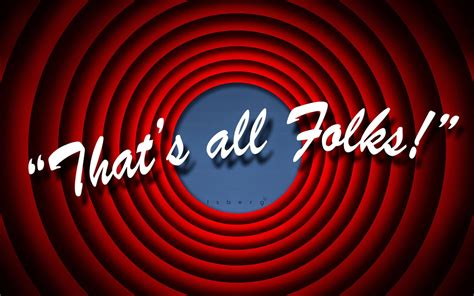